In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-white")


C:\Users\Kevin\AppData\Local\Temp\ipykernel_3536\1806114291.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


#### 0 a)

,Minutes,SEK
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051


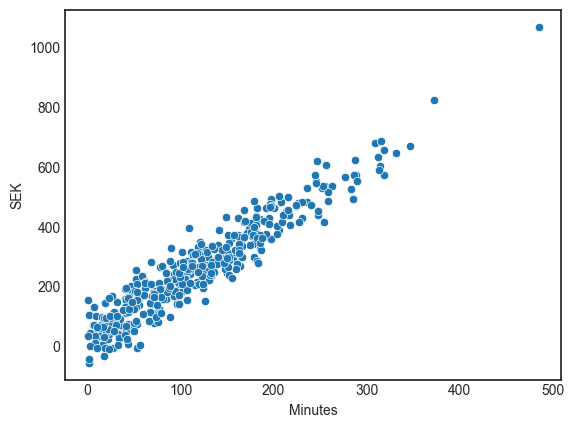

In [149]:
np.random.seed(42)

df = pd.DataFrame()

# Explanetory variable (x)
df['Minutes'] = np.random.normal(100, 100, size=400)
df['Minutes'] = df['Minutes'].abs()

noise = np.random.normal(0, 50, size=400)

# Response variable (y)
df['SEK'] = 2 * df['Minutes'] + 25 + noise

sns.scatterplot(data=df, x='Minutes', y='SEK')
df.head()

#### 0 b)

<AxesSubplot: xlabel='Minutes', ylabel='SEK'>

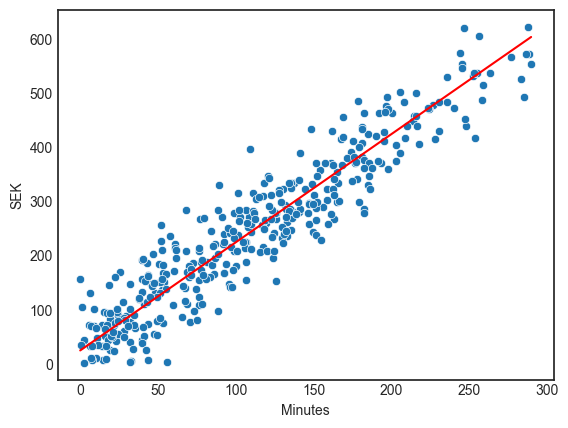

In [167]:
df = df.drop(df[df['Minutes'] > 300].index)
df = df.drop(df[df['SEK'] < 0].index)

# Constants, usually computed by alg, but given here as part of excersize
b0 = 25 # intercept (bias)
b1 = 2 # x multiplier (weight)
x, y = df['Minutes'], df['SEK']

# y (grund truth)
y_hat = lambda x: b0 + b1*x
ground_truth = y_hat(x) # for use later on

# Plot ground truth over noisy data
sns.scatterplot(data=df, x='Minutes', y='SEK')
sns.lineplot(data=df, x=df["Minutes"], y=y_hat(x), color='red')

#### 0 c)

In [165]:
df.head()

,Minutes,SEK
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051


#### 1 a)

In [152]:
def train_test_split(df: pd.DataFrame, train_fraction: float, seed: int, replace: bool) -> tuple:
    # isnt actually needed, as you can use df.sample(frac=) directly
    numeric_fraction = int(len(df) * train_fraction) # using int() to round. is using round better or worse?
    
    train = df.sample(n=numeric_fraction, replace=replace, random_state=seed)
    test = df.drop(train.index)
    
    # For extra clarity.
    x_train = train['Minutes']
    x_test = test['Minutes']
    y_train = train['SEK']
    y_test = test['SEK']
    
    return x_train, x_test, y_train, y_test # Returns a tuple

In [157]:
# (X_train, X_test, y_train, y_test)
x_train, x_test, y_train, y_test = train_test_split(df, train_fraction=0.7, seed=42, replace=False)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((266,), (115,), (266,), (115,))

In [158]:
# Convert from pandas vectors to numpy (n, 2) matrices
x_train_matrix = np.array(x_train).reshape(-1, 1)
x_test_matrix = np.array(x_test).reshape(-1, 1)
y_train_matrix = np.array(y_train).reshape(-1, 1)
y_test_matrix = np.array(y_test).reshape(-1, 1)

x_train_matrix.shape, x_test_matrix.shape, y_train_matrix.shape, y_test_matrix.shape

((266, 1), (115, 1), (266, 1), (115, 1))

#### 2

In [162]:
# NOTE: The intercept isn't part of the explanatory variables, and is strictly computed and added
# as a coordinate system reference point.

# Add intercept constant multiplier (1x multiplier for making shapes match)
x_train_matrix = np.c_[np.ones(len(x_train)), x_train]
x_test_matrix = np.c_[np.ones(len(x_test)), x_test]

# Core equation for actually calculating the lowest sum of squared residuals (e.g lowest loss function)
# using the ordinary least squares algorithm
regression_fit = lambda X, y: np.linalg.pinv(X.T @ X) @ X.T @ y

beta_hat = regression_fit(x_train_matrix, y_train)
beta_hat # weight and bias (intercept)

array([32.22147722,  1.91050591])

<AxesSubplot: xlabel='Minutes', ylabel='SEK'>

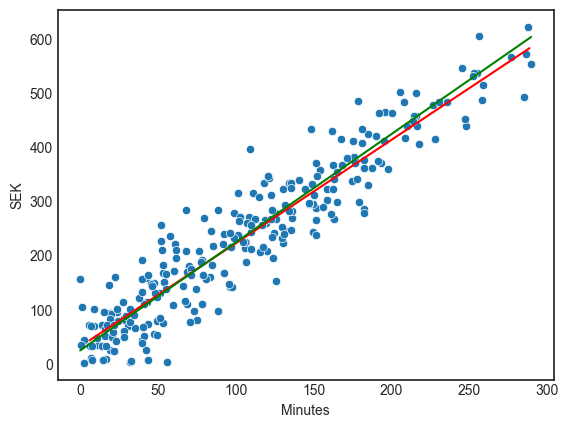

In [168]:
y_hat = lambda x: beta_hat[0] + beta_hat[1] * x

sns.scatterplot(x=x_train, y=y_train)
sns.lineplot(x=x_test, y=y_hat(x_test), color='red')

# Ground truth
sns.lineplot(x=df["Minutes"], y=ground_truth, color='green')

#### 3 a)

<AxesSubplot: xlabel='Minutes', ylabel='SEK'>

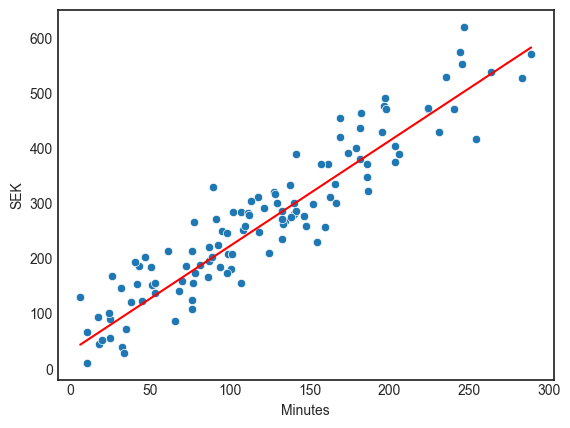

In [169]:
# Using model on test data
sns.scatterplot(x=x_test, y=y_test)
sns.lineplot(x=x_test, y=y_hat(x_test), color='red')

#### 3 b)

In [136]:
# training - we fit the weights beta_hat to the training data
beta_hat = regression_fit(x_train_matrix, y_train_matrix)
print(f"Regression coefficients beta: {beta_hat.flatten()}")

# we generalize the predict to work for matrix with many samples
predict = lambda X, weights: X @ weights

# note that X_test shape is (60, 1) and beta_hat shape needs to be (4,1)
y_hat = predict(x_test_matrix, beta_hat)

print(f"Shape of y_hat is {y_hat.shape}, i.e. prediction for each sample in test set")

print(f"TV, Radio, Newspaper spending of {x_test.iloc[0]} gives prediction of {y_hat[0][0]:.1f} thousand units")
print(f"The true sale label is y = {y_test.iloc[0]} thousand units")

Regression coefficients beta: [32.22147722  1.91050591]
Shape of y_hat is (115, 1), i.e. prediction for each sample in test set
TV, Radio, Newspaper spending of 86.17356988288154 gives prediction of 196.9 thousand units
The true sale label is y = 167.37838861807444 thousand units


In [137]:
m = len(y_test)
y_hat = np.reshape(y_hat, (m))  # removes the extra dimension

MAE = 1 / m * np.sum(np.abs(y_test - y_hat))
MSE = 1 / m * np.sum((y_test - y_hat) ** 2)
RMSE = np.sqrt(MSE)

for metric in [
    ("Mean absolute error", "MAE", "k units"),
    ("Mean squared error", "MSE", "M units"),  
    ("Root mean square error", "RMSE", "k units"),
]:
    print(f"{metric[0]}: {eval(metric[1]):.2f}{metric[2]}")

Mean absolute error: 40.12k units
Mean squared error: 2401.58M units
Root mean square error: 49.01k units


#### 4 a)
###### Note: not bothering to create dataset, display, clean and than display again. Just creating and displaying the cleaned one from the get go.

In [138]:
np.random.seed(42)

df = pd.DataFrame()

# Dont forget to specify size
size = 10000

# Original dataset
df['minutes'] = np.absolute(np.random.normal(100, 100, size=size))
df['smses'] = np.random.randint(0, 50, size=size)
df['Gbs'] = np.absolute(np.random.normal(0, 2, size=size))
Epsilon = np.random.normal(0, 50, size=size)

# for clarity
x1 = df['minutes']
x2 = df['smses']
x3 = df['Gbs']
Epsilon = Epsilon


df['Total cost'] = 25 + 2 * x1 + 0.5 * x2 + 50 * x3 + Epsilon
df

,minutes,smses,Gbs,Total cost
0,149.671415,41,2.263011,502.396003
1,86.173570,16,0.031570,179.072107
2,164.768854,30,0.808925,430.008213
3,252.302986,33,2.625826,647.244277
4,76.584663,37,3.388079,398.016588
...,...,...,...,...
9995,230.110206,36,0.611639,473.661741
9996,99.834497,18,1.328020,298.342321
9997,29.468328,19,2.811456,252.973057
9998,149.576557,31,3.439294,536.176482


#### 4 b)

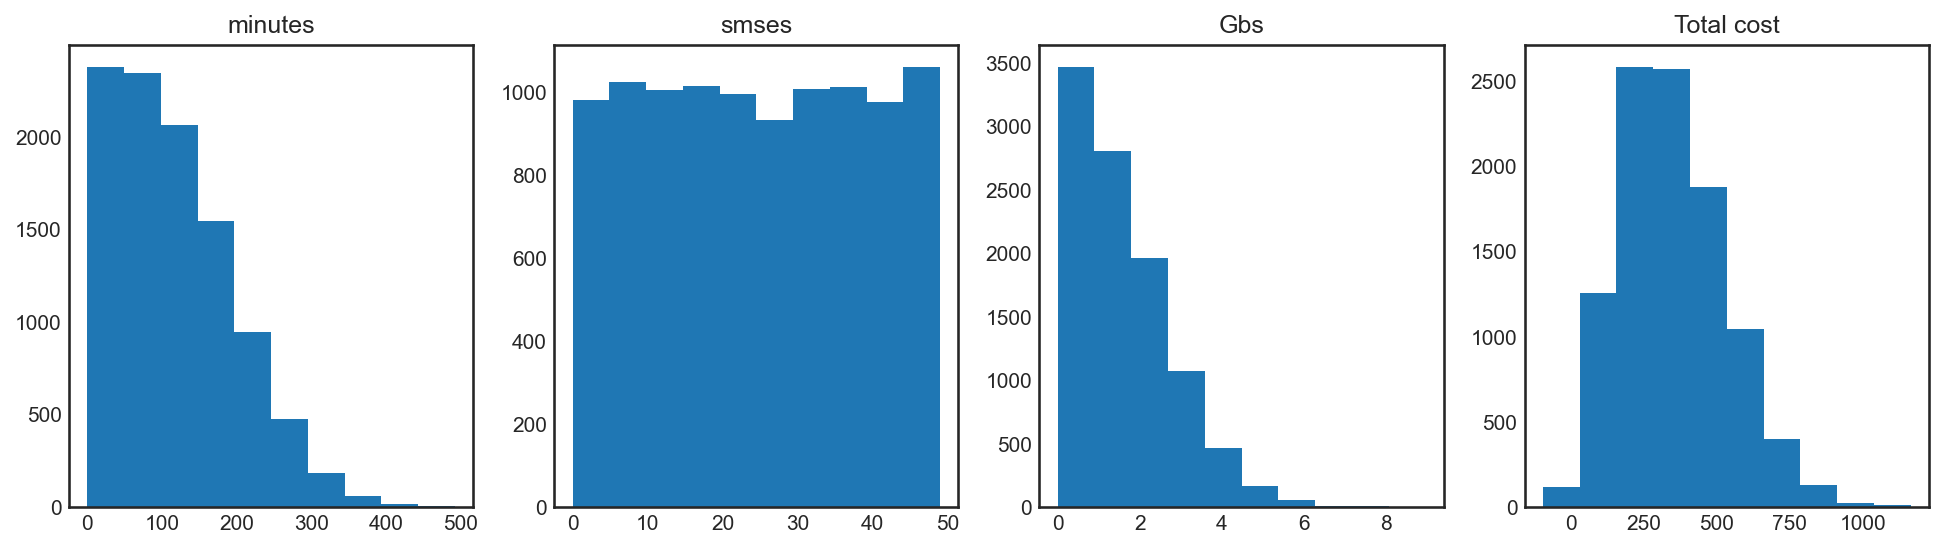

In [139]:
fig, ax = plt.subplots(1, 4, figsize = (16,4), dpi = 150)

for i in range(4):
    ax[i].hist(x = df.iloc[:, i])
    #sns.histplot(data = df, x = df.iloc[:, i], ax=ax[i])
    ax[i].set_title(f"{df.iloc[:, i].name}")

#### 4 c)

In [140]:
df = df.drop(df[df['Gbs'] >= 4].index)
df = df.drop(df[df['minutes'] >= 300].index)
df = df.drop(df[df['Total cost'] <= 0].index)

df

,minutes,smses,Gbs,Total cost
0,149.671415,41,2.263011,502.396003
1,86.173570,16,0.031570,179.072107
2,164.768854,30,0.808925,430.008213
3,252.302986,33,2.625826,647.244277
4,76.584663,37,3.388079,398.016588
...,...,...,...,...
9995,230.110206,36,0.611639,473.661741
9996,99.834497,18,1.328020,298.342321
9997,29.468328,19,2.811456,252.973057
9998,149.576557,31,3.439294,536.176482


#### 4 d)

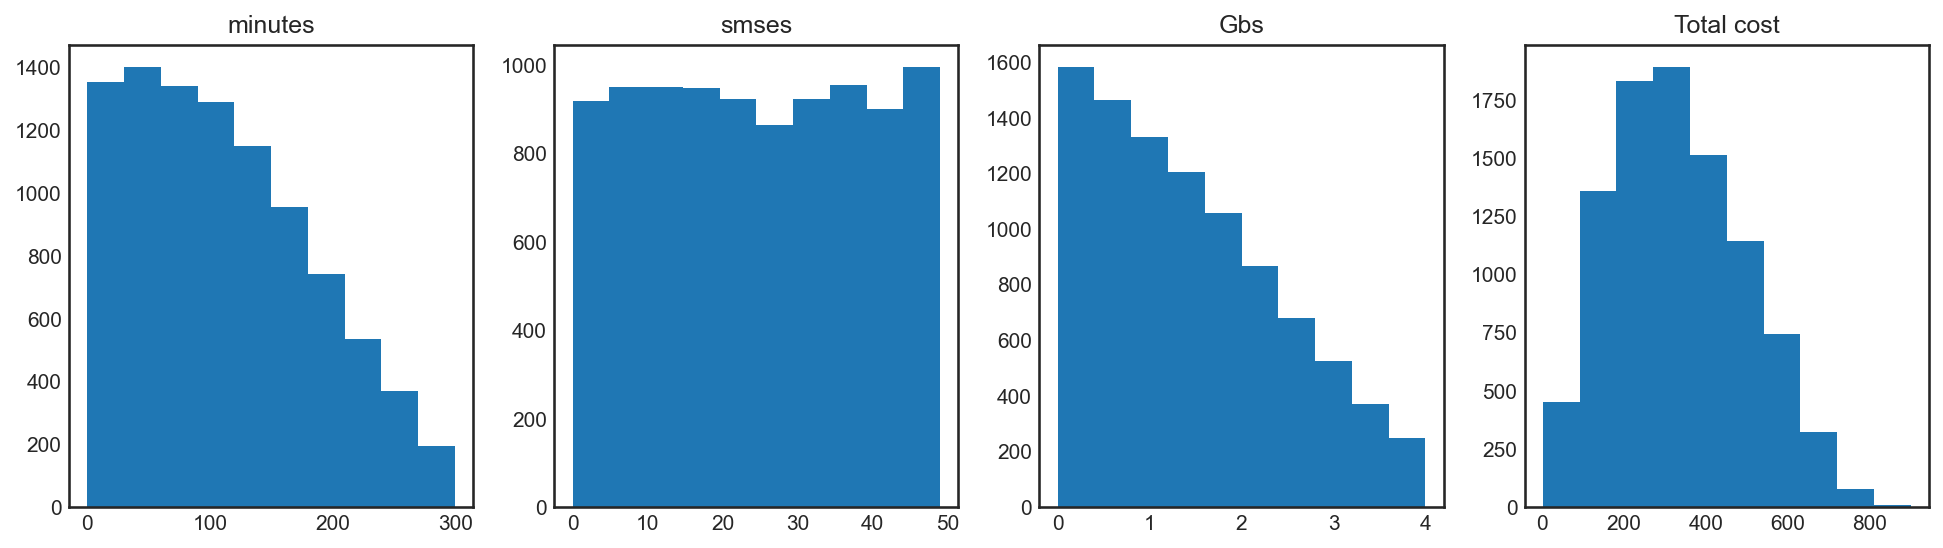

In [141]:
fig, ax = plt.subplots(1, 4, figsize = (16,4), dpi = 150)

for i in range(4):
    ax[i].hist(x = df.iloc[:, i])
    #sns.histplot(data = df, x = df.iloc[:, i], ax=ax[i])
    ax[i].set_title(f"{df.iloc[:, i].name}")

#### 5 a)

In [142]:
train = df.sample(frac=0.8, replace=False, random_state=42)
test = df.drop(train.index)

train.shape, test.shape

((7456, 4), (1864, 4))

In [143]:
x_train = train.drop('Total cost', axis=1)
y_train = train['Total cost']

x_test = test.drop('Total cost', axis=1)
y_test = test['Total cost']

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7456, 3), (1864, 3), (7456,), (1864,))

#### 5 b)

In [144]:
x_train.insert(0, "Intercept", 1)
x_test.insert(0, "Intercept", 1)

x_train

,Intercept,minutes,smses,Gbs
1633,1,202.996082,39,1.536647
8188,1,168.233878,23,3.498326
7632,1,196.532667,25,0.075701
1035,1,257.398676,33,1.201828
2977,1,15.368402,0,0.822560
...,...,...,...,...
682,1,47.547973,0,1.727655
8948,1,133.276048,46,1.182865
3310,1,18.187413,23,0.880496
3729,1,131.614386,0,1.927903


In [145]:
def OLS_reg(x, y):
    beta_hat = np.linalg.inv(x.T @ x) @ x.T @ y
    return beta_hat

beta_hat = OLS_reg(x_train, y_train)
beta_hat

0    26.509517
1     1.995119
2     0.524720
3    48.971645
dtype: float64

In [146]:
def predict(x, betas):
    # Note: np.dot is a lot more forgiving than matmul, so you'd need to convert to np arrays and add dimention
    return np.dot(x, betas)

# test_sample = [1, 202, 39, 1.5] for single prediction
y_hat = predict(x_test, beta_hat)
y_hat


array([208.37760252, 410.59900516, 364.63948276, ..., 176.62390041,
       192.76763499, 232.95366942])

#### c)

In [147]:
m = len(y_test)

mean_absolute_error = 1/m*np.sum(np.abs(y_test-y_hat))
mean_squared_error = 1/m*np.sum((y_test-y_hat)**2)
root_mean_squared_error = np.sqrt(mean_squared_error)

mean_absolute_error, mean_squared_error, root_mean_squared_error

# error given samples of data
# many: 39.72641445614409, 2477.9779170142556, 49.77929205015129)
# few: 36.717330327045744, 2050.7563162407705, 45.285277036149076

(39.237711559716004, 2421.2614765161297, 49.20631541292367)